# Digital Terrain Model (DTM)

This notebook wants to explain how to handle a digital terrain model file in Python. Digital Terrain Models (DTM) sometimes called Digital Elevation Models (DEM) is a topographic model of the bare Earth that can be manipulated by computer programs.The data files contain the elevation data of the terrain in a digital format.
The use of a DTM is particularly important in the orthorectification process of satellite images. Indeed, satellite imagery inherently contains distortions caused by many factors like sensor orientation and topographical variation. The correction of these distortions is referred to as orthorectification and can be obtained using a digital terrain model.

In [1]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent
import numpy as np

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

In [ ]:
#EarthPy contains a helper class that supports downloaded sets of pre-created data 
#subsets designed for the Earth Lab Earth Analytics online courses
et.data.get_data("colorado-flood")


In [2]:
os.chdir(os.path.join(et.io.HOME, 
                      'earth-analytics', 
                      'data'))

In [3]:
# Define relative path to file
dem_pre_path = os.path.join("colorado-flood",
                            "spatial",
                            "boulder-leehill-rd",
                            "pre-flood",
                            "lidar",
                            "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

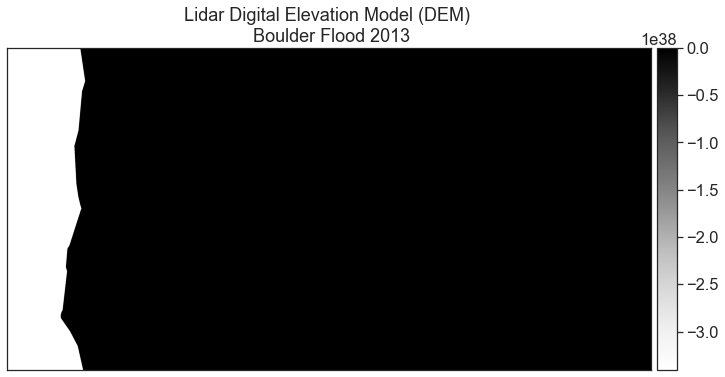

In [4]:
# Plot your data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()


If we plot data in this way we will not see the digital model elevation because of the scale and the presence of some outlieres that need to be removed or changed or the presence of pixels with no data values. In order to check the presence of outliers or no data values we can both print the min/max values and histograms to graphically visulize the range values.

In [5]:
print("Minimum raster value: ", dtm_pre_arr.min())
print("Maximum raster value: ", dtm_pre_arr.max())

Minimum raster value:  -3.4028235e+38
Maximum raster value:  2087.43


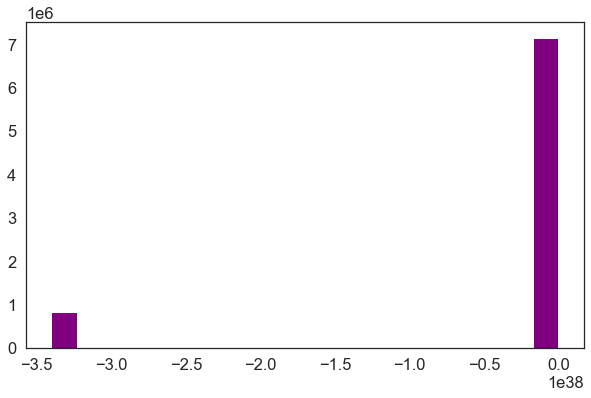

In [6]:
# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below?
ep.hist(dtm_pre_arr,
        figsize=(10, 6))
plt.show()

In [7]:
# We can trying by reading again the file and masking the no data values
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1, masked=True)
    width = dem_src.width
    height = dem_src.height

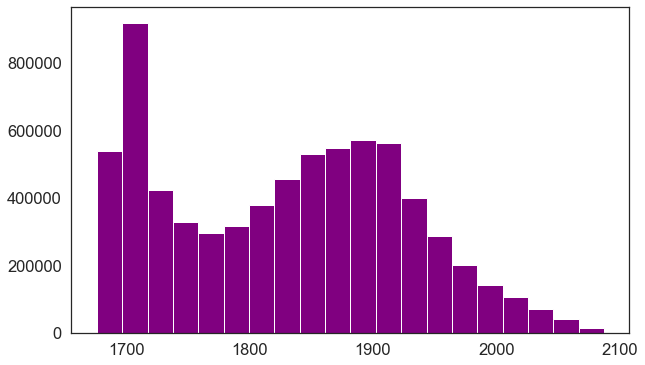

In [8]:
ep.hist(dtm_pre_arr,
        figsize=(10, 6))
plt.show()

In [9]:
print("Minimum raster value: ", dtm_pre_arr.min())
print("Maximum raster value: ", dtm_pre_arr.max())

Minimum raster value:  1676.21
Maximum raster value:  2087.43


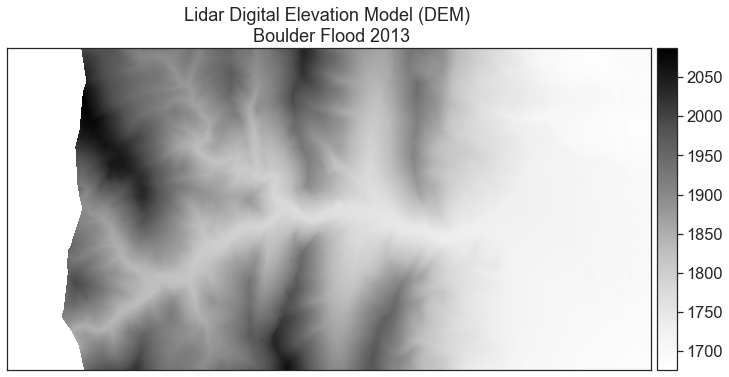

In [10]:
# Now it looks better, we can try to plot again the map
# Plot your data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

C:\Users\degas\anaconda3\envs\satelliteimg\lib\site-packages\numpy\ma\core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
C:\Users\degas\anaconda3\envs\satelliteimg\lib\site-packages\numpy\ma\core.py:1015: RuntimeWarning: overflow encountered in add
  result = self.f(da, db, *args, **kwargs)
C:\Users\degas\anaconda3\envs\satelliteimg\lib\site-packages\earthpy\spatial.py:620: RuntimeWarning: invalid value encountered in sqrt
  slope = np.pi / 2.0 - np.arctan(np.sqrt(x * x + y * y))


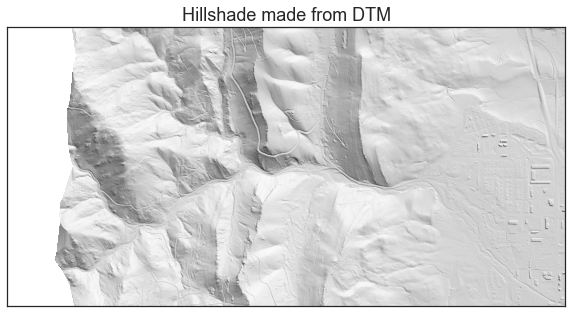

In [11]:
# We can also plot the hillshade
# Create and plot the hillshade with earthpy
hillshade = et.spatial.hillshade(dtm_pre_arr)

ep.plot_bands(
    hillshade,
    cbar=False,
    title="Hillshade made from DTM",
    figsize=(10, 6),
)
plt.show()



In [12]:
# We can also plot the DTM and the hillshade at the same time

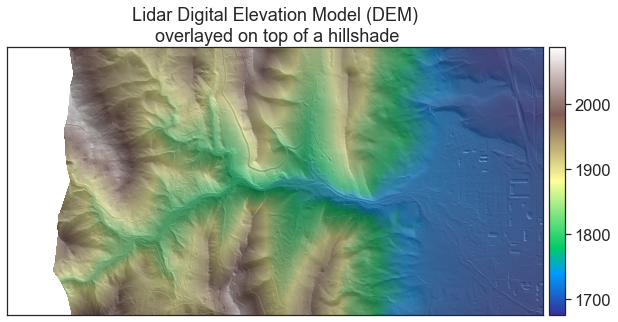

In [13]:
# Plot the DEM and hillshade at the same time
# sphinx_gallery_thumbnail_number = 5
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    dtm_pre_arr,
    ax=ax,
    cmap="terrain",
    title="Lidar Digital Elevation Model (DEM)\n overlayed on top of a hillshade",
)
ax.imshow(hillshade, cmap="Greys", alpha=0.5)
plt.show()

So far we have seen how to do a 2D plot of a DTM. We will now see how to make a 3D plot.

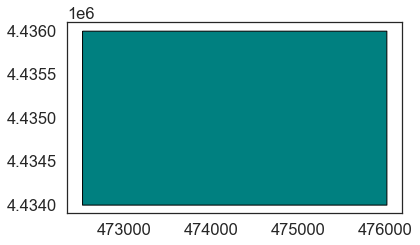

In [14]:
# Open site boundary vector layer
site_bound_path = os.path.join("colorado-flood",
                               "spatial",
                               "boulder-leehill-rd",
                               "clip-extent.shp")

site_bound_shp = gpd.read_file(site_bound_path)

# Plot the vector data
site_bound_shp.plot(color='teal',
                    edgecolor='black')
plt.show()



In [15]:
# To see the min/max values
site_bound_shp['geometry'].bounds

,minx,miny,maxx,maxy
0,472510.465116,4434000.0,476010.465116,4436000.0


In [16]:
# Generate a grid
minx = site_bound_shp['geometry'].bounds['minx'].values.item()
miny = site_bound_shp['geometry'].bounds['miny'].values.item()
maxx = site_bound_shp['geometry'].bounds['maxx'].values.item()
maxy = site_bound_shp['geometry'].bounds['maxy'].values.item()

In [17]:
xCoord = np.linspace(minx, maxx, num=width)
yCoord = np.linspace(miny, maxy, num=height)

In [18]:
# Make a 3D plot of the DTM with matplot lib
from mpl_toolkits.mplot3d.axes3d import *
import matplotlib.pyplot as plt
from matplotlib import cm

In [32]:
X, Y = np.meshgrid(xCoord, yCoord)
Z =  dtm_pre_arr
X = np.ma.masked_array(X, mask=Z.mask)
Y = np.ma.masked_array(Y, mask=Z.mask)
#Z[Z.mask] = np.nan
#X[X.mask] = np.nan
#Z[Y.mask] = np.nan

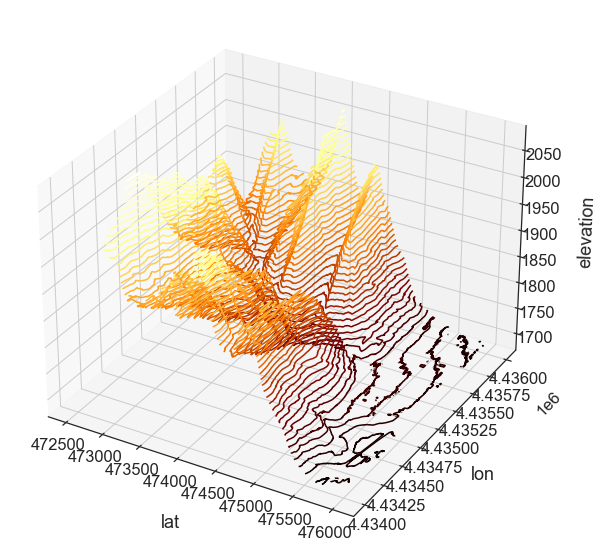

In [50]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
pnt3d = ax.contour3D(X, Y, Z, 50,cmap='afmhot')
#cbar=plt.colorbar(pnt3d)
ax.set_xlabel('lat')
ax.set_ylabel('lon')
ax.set_zlabel('elevation')
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20
